# Contexto e Dados

### Contexto
Os datasets em conjunto registram dados de pescas de mais de 200 espécies de peixes e conchas no Ocêano Atlântico. Esses dados foram oficialmente registrados por 20 países que participam do Conselho Internacional de Exploração Marítima (ICES) entre 2006 e 2014.<br>
Fonte: https://www.kaggle.com/datasets/victorgenin/ices-fish-catch?select=species.txt

### Dados
Exitsem 4 fontes de dados, são elas:
- **country_codes.csv**
  <br>Tabela contendo metadados dos países. 6 atributos: `code`, `description`, `codeType`, `deprecated`, `created`, `modified`.
- **fish_catches.csv**
  <br>Tabela contendo registros de captura. 24 atributos: `species`, `area`, `units`, `country`, `2014`, `2013`, `2012`, `2011`, `2010`, `2009`, `2008`, `2007`, `2006`, e o restante inacessível
- **fishing_area.xml**
  <br>Objeto contendo dados das subdivisões das áreas do oceano Atlântico (schema ainda não identificado)
- **species.txt**
  <br>Arquivo texto contendo informação das espécies de peixes. 11 atributos: `ISSCAAP`, `TAXOCODE`, `3A_CODE`, `Scientific_name`, `English_name`, `French_name`, `Spanish_name`, `Author`, `Family`, `Order`, `Stats_data`

# Planejamento

1. As 4 base de dados deverão ser ingeridas e armazenadas
2. Para cade base de dado originalmente do tipo csv ou txt, serão criados objetos do tipo Dataframe com o parser padrão do leitor desses arquivos
3. Será escolhido uma biblioteca ou criado uma função simples para parsear a fonte de dados de formato xml, e transformada em Dataframe
4. Para cada base de dados, já no formato Dataframe, será aplicado funções de tratamento de dados (correção de texto, tratamento de nulos, formatação, etc)
5. Será avaliado a necessidade de remodelagem das bases para facilitar o uso analítico. Se viável, uma remodegalem será feita em cima das 4 tabelas
6. Criação de um dicionário de dados para cada fonte, em formato yaml

### Pacotes e imports

In [1]:
import pandas as pd

Gerar novo token do Kaggle: https://www.kaggle.com/settings
Baixar kaggle.json e subir na pasta content

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

## Ingestão

In [6]:
! kaggle datasets download victorgenin/ices-fish-catch

  0% 0.00/741k [00:00<?, ?B/s]
100% 741k/741k [00:00<00:00, 97.7MB/s]


In [7]:
! unzip ices-fish-catch

Archive:  ices-fish-catch.zip
  inflating: country_codes.csv       
  inflating: fish_catches.csv        
  inflating: fishing_area.xml        
  inflating: species.txt             


### fishing_areas.xml
Esse dataset será tratado posteriormente devido ao custo benefício (esforço vs entrega de valor), visto que o esforço para parsear XML é alto enquanto o valor desses dados não é fundamental, e sim como enriquecimento

In [289]:
# fishing_areas_raw = pd.read_txt("/content/fishing_areas.xml")
# fishing_areas_raw.head(5)

Através da visualização manual desse arquivo XML, é possível entender a estrutura de dados:




Area

```
<fi:Area Type="Area">
<fi:AreaProfile>
⠀<fi:AreaStruct>
⠀⠀ <fi:Area Type="Subarea">
⠀⠀⠀ <fi:AreaIdent Status="3">
⠀⠀⠀⠀ <fi:Name>Barents Sea (Subarea I)</fi:Name>
⠀⠀⠀⠀ <fi:WaterAreaRef Code="27.1" CodeSystem="FAO_area" Type="Statistical"/>
⠀⠀⠀ <fi:AreaProfile>
⠀⠀⠀⠀ <fi:Format Header="Large">Barents Sea (Subarea I)</fi:Format>
⠀⠀⠀⠀ <fi:AreaStruct>
⠀⠀⠀⠀⠀ <fi:Area Type="Division">
⠀⠀⠀⠀⠀⠀ <fi:AreaIdent Status="3">
⠀⠀⠀⠀⠀⠀⠀ <fi:Name>Barents Sea - NEAFC Regulatory Area (Division Ia)</fi:Name>
⠀⠀⠀⠀⠀⠀⠀ <fi:WaterAreaRef Code="27.1.a" CodeSystem="FAO_area" Type="Statistical"/>
⠀⠀⠀⠀⠀⠀ <fi:AreaProfile>
⠀⠀⠀⠀⠀⠀⠀ <fi:Format Header="Medium">Sound and Belt Sea or the Transition Area (Divisions IIIb, c)</fi:Format>
⠀⠀⠀⠀⠀⠀⠀ <fi:AreaStruct>
⠀⠀⠀⠀⠀⠀⠀⠀ <fi:Area Type="Subdivision">
⠀⠀⠀⠀⠀⠀⠀⠀⠀ <fi:AreaIdent Status="3">
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ <fi:Name>Belt Sea (Subdivision 22)</fi:Name>
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ <fi:WaterAreaRef Code="27.3.c.22" CodeSystem="FAO_area" Type="Statistical"/>
⠀⠀⠀⠀⠀⠀⠀⠀⠀ <fi:AreaProfile>
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ <fi:Format Header="Small">Belt Sea (Subdivision 22)</fi:Format>
```











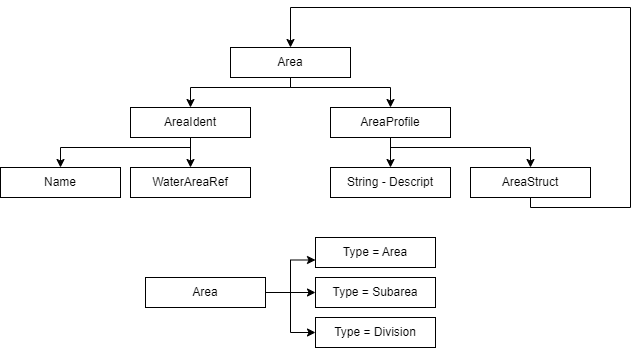

In [290]:
from IPython.display import Image
Image('/content/diagram.png')

In [291]:
from xml.dom.minidom import parse, parseString
document = parse("/content/fishing_area.xml")

In [292]:
lista = []
for areas in document.getElementsByTagName("fi:Area"):
  name = areas.getElementsByTagName("fi:Name")[0].firstChild.nodeValue
  code = areas.getElementsByTagName("fi:WaterAreaRef")[0].getAttribute("Code")
  lista.append((name, code))

fishing_areas_df = pd.DataFrame(lista, columns=['name', 'code'])

### species.txt

In [293]:
species_raw = pd.read_csv("/content/species.txt" , delimiter = "\t", encoding = "ISO-8859-1")
species_raw.head(5)

,ISSCAAP,TAXOCODE,3A_CODE,Scientific_name,English_name,French_name,Spanish_name,Author,Family,Order,Stats_data
0,25.0,1020100101,LAU,Petromyzon marinus,Sea lamprey,Lamproie marine,Lamprea marina,Linnaeus 1758,Petromyzontidae,PETROMYZONTIFORMES,1
1,25.0,1020100201,LAR,Lampetra fluviatilis,River lamprey,Lamproie de rivière,Lamprea de río,(Linnaeus 1758),Petromyzontidae,PETROMYZONTIFORMES,1
2,25.0,1020100203,IDK,Lampetra aepyptera,Least brook lamprey,Petite lamproie de ruisseau,NaN,(Abbott 1860),Petromyzontidae,PETROMYZONTIFORMES,0
3,25.0,1020100204,IDL,Lampetra ayresii,Western American river lamprey,Lamproie de rivière de lOuest,NaN,(Günther 1870),Petromyzontidae,PETROMYZONTIFORMES,0
4,25.0,1020100205,IDN,Lampetra planeri,European brook lamprey,Lamproie de ruisseau d'Europe,NaN,(Bloch 1784),Petromyzontidae,PETROMYZONTIFORMES,0


### fish_catches.csv

In [294]:
fish_catches_raw = pd.read_csv("/content/fish_catches.csv")
fish_catches_raw.head(5)

,Species,Area,Units,Country,2014,2013,2012,2011,2010,2009,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,ANF,27,TLW,BE,993.0,1633.0,1716.0,1279.0,1031.0,853.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANF,27.4,TLW,BE,217.0,137.0,133.0,116.0,131.0,140.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ANF,27.4.A,TLW,BE,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ANF,27.4.B,TLW,BE,213.0,135.0,131.0,111.0,124.0,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ANF,27.4.C,TLW,BE,4.0,2.0,2.0,6.0,7.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### country_codes.csv

In [295]:
country_codes_raw = pd.read_csv("/content/country_codes.csv")
country_codes_raw.head(5)

,Code,Description,CodeType,Deprecated,Created,Modified,
0,ALL,All countries used when reporting survey indices,IC_Country,False,2006-10-23,2006-10-23,
1,BE,Belgium,IC_Country,False,2006-10-23,2006-10-23,
2,BG,Bulgaria,IC_Country,False,2012-08-08,2012-08-08,
3,CA,Canada,IC_Country,False,2007-06-22,2007-06-22,
4,DE,Germany,IC_Country,False,2006-10-23,2006-10-23,


## Pré Tratamento

Inicialmente serão selecionadas as colunas principais, renomeadas e também conformadas para strings com formato padrão (seja capitalizado ou totalmente em caixa alta)

In [296]:
import numpy as np
## fishing_areas
fishing_areas_df = pd.DataFrame(lista, columns=['name', 'code'])
fishing_areas_df[['area', 'subarea', 'division', 'subdivision', 'unit']] = fishing_areas_df['code'].str.split('.', expand=True)
fishing_areas_df['location__name'] = fishing_areas_df['name']
fishing_areas_df['location__code'] = fishing_areas_df['code'].str.upper()

condicoes = [
    (fishing_areas_df['unit'].notnull()),
    (fishing_areas_df['unit'].isnull()) & (fishing_areas_df['subdivision'].notnull()),
    (fishing_areas_df['subdivision'].isnull()) & (fishing_areas_df['division'].notnull()),
    (fishing_areas_df['division'].isnull()) & (fishing_areas_df['subarea'].notnull()),
    (fishing_areas_df['subarea'].isnull()) & (fishing_areas_df['area'].notnull()),
]

resultados = [
    'Unit', 'Subdivision', 'Division', 'Subarea', 'Area'
]

fishing_areas_df['type'] = np.select(condicoes, resultados)

fishing_areas_df.drop(columns = ['area', 'subarea', 'division', 'subdivision', 'unit', 'code' ,'name'], inplace=True)

In [297]:

## species
species = species_raw
species["family"] = species["Family"]
species["order"] = species["Order"].str.capitalize()
species["name_scientific"] = species["Scientific_name"].str.capitalize()
species["name_common"] = species["English_name"].str.capitalize()
species["species__species_code"] = species["3A_CODE"].str.upper()
species = species[["species__species_code", "name_scientific", "name_common", "family", "order"]]

## fish_catches
fish_catches = fish_catches_raw
fish_catches["fish_catches__species_code"] = fish_catches["Species"].str.upper()
fish_catches["fish_catches__country_code"] = fish_catches["Country"].str.upper()
fish_catches["area"] = fish_catches["Area"]
fish_catches["units"] = fish_catches["Units"]
fish_catches = fish_catches[["fish_catches__species_code", "area", "units", "fish_catches__country_code", "2014", "2013", "2012", "2011", "2010", "2009", "2008", "2007", "2006"]]


## country_codes
country_codes = country_codes_raw
country_codes["country_codes__country_code"] = country_codes["Code"].str.upper()
country_codes["description"] = country_codes[" Description"]
country_codes = country_codes[["country_codes__country_code", "description"]]

No próximo passo, o dataset principal, que contém métricas, será modificado do formato wide para o formato long, reduzindo 6 dimensões (ano 2006 a ano 2014) para uma única dimensão, indicadora do ano. Dessa forma, o analista de negócios poderá criar filtros em cima do ano.

In [298]:
fish_catches_no_idx = fish_catches.reset_index()
fish_catches_long = pd.melt(fish_catches_no_idx, id_vars=['fish_catches__species_code', 'area', 'units', 'fish_catches__country_code'], value_vars=[ "2014", "2013", "2012", "2011", "2010", "2009", "2008", "2007", "2006"])
fish_catches_long["year"] = fish_catches_long["variable"]
fish_catches_long["quantity"] = fish_catches_long["value"].apply(pd.to_numeric)
fish_catches_long = fish_catches_long.drop(columns=['variable', 'value'])
fish_catches_long = fish_catches_long.astype({'year': 'int32'})
## os valores de contagem `quantity` (anteriormente distribuido nas colunas de ano) parecem ser inteiros, avaliar mudanca float64 -> int32
fish_catches_long.head(2)

,fish_catches__species_code,area,units,fish_catches__country_code,year,quantity
0,ANF,27,TLW,BE,2014,993.0
1,ANF,27.4,TLW,BE,2014,217.0


### Verificação de Nulos

No último passo, serão verificados valores nulos para imputação de um valor padrão para indicar nulos, do mesmo tipo de dado da coluna

In [299]:
fishing_areas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   location__name  98 non-null     object
 1   location__code  98 non-null     object
 2   type            98 non-null     object
dtypes: object(3)
memory usage: 2.4+ KB


### Species

In [301]:
species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   species__species_code  12600 non-null  object
 1   name_scientific        12600 non-null  object
 2   name_common            9469 non-null   object
 3   family                 12502 non-null  object
 4   order                  12600 non-null  object
dtypes: object(5)
memory usage: 492.3+ KB


In [302]:
species = species.fillna({"name_common": "Not identifiable", "family": 'Not identifiable'})

In [306]:
species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   species__species_code  12600 non-null  object
 1   name_scientific        12600 non-null  object
 2   name_common            12600 non-null  object
 3   family                 12600 non-null  object
 4   order                  12600 non-null  object
dtypes: object(5)
memory usage: 492.3+ KB


### Fish Catches

In [303]:
fish_catches_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441990 entries, 0 to 441989
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   fish_catches__species_code  441981 non-null  object 
 1   area                        441981 non-null  object 
 2   units                       441981 non-null  object 
 3   fish_catches__country_code  441981 non-null  object 
 4   year                        441990 non-null  int32  
 5   quantity                    441981 non-null  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 18.5+ MB


Parece haver algumas linhas nulas decorrentes de uma única linha nula anterior ao processo de transformação de formato (wide -> long)

In [304]:
fish_catches_long[(fish_catches_long["area"].isna())]

,fish_catches__species_code,area,units,fish_catches__country_code,year,quantity
49109,NaN,NaN,NaN,NaN,2014,NaN
98219,NaN,NaN,NaN,NaN,2013,NaN
147329,NaN,NaN,NaN,NaN,2012,NaN
196439,NaN,NaN,NaN,NaN,2011,NaN
245549,NaN,NaN,NaN,NaN,2010,NaN
294659,NaN,NaN,NaN,NaN,2009,NaN
343769,NaN,NaN,NaN,NaN,2008,NaN
392879,NaN,NaN,NaN,NaN,2007,NaN
441989,NaN,NaN,NaN,NaN,2006,NaN


In [305]:
## filtrando apenas linhas que não são completamente nulas, usando a coluna area como referencia
fish_catches_long = fish_catches_long[(fish_catches_long["area"].notnull())]
fish_catches = fish_catches_long

### Country Codes

In [18]:
country_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country_codes__country_code  34 non-null     object
 1   description                  34 non-null     object
dtypes: object(2)
memory usage: 672.0+ bytes


## Disponibilização dos dados pré tratados

In [34]:
!mkdir /content/staging

In [307]:
path = "/content/staging/fishing_areas.csv"
fishing_areas_df.to_csv(path)

In [308]:
path = "/content/staging/species.csv"
species.to_csv(path)

In [309]:
path = "/content/staging/fish_catches.csv"
fish_catches.to_csv(path)

In [310]:
path = "/content/staging/country_codes.csv"
country_codes.to_csv(path)

## Remodelagem

In [312]:
species = pd.read_csv("/content/staging/species.csv")
fish_catches = pd.read_csv("/content/staging/fish_catches.csv")
country_codes = pd.read_csv("/content/staging/country_codes.csv")
fishing_areas = pd.read_csv("/content/staging/fishing_areas.csv")

In [314]:
fishing_areas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      98 non-null     int64 
 1   location__name  98 non-null     object
 2   location__code  98 non-null     object
 3   type            98 non-null     object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB


In [313]:
species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             12600 non-null  int64 
 1   species__species_code  12600 non-null  object
 2   name_scientific        12600 non-null  object
 3   name_common            12600 non-null  object
 4   family                 12600 non-null  object
 5   order                  12600 non-null  object
dtypes: int64(1), object(5)
memory usage: 590.8+ KB


In [316]:
fish_catches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441981 entries, 0 to 441980
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  441981 non-null  int64  
 1   fish_catches__species_code  441981 non-null  object 
 2   area                        441981 non-null  object 
 3   units                       441981 non-null  object 
 4   fish_catches__country_code  441981 non-null  object 
 5   year                        441981 non-null  int64  
 6   quantity                    441981 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 23.6+ MB


In [317]:
country_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   34 non-null     int64 
 1   country_codes__country_code  34 non-null     object
 2   description                  34 non-null     object
dtypes: int64(1), object(2)
memory usage: 944.0+ bytes


### Join entre espécies e pescas (fato)

In [318]:
fish_catches_species = fish_catches.merge(species, left_on='fish_catches__species_code', right_on='species__species_code')
fish_catches_species= fish_catches_species.drop(axis=1,columns=["fish_catches__species_code", "species__species_code"])

In [319]:
fish_catches_species.head(5)

,Unnamed: 0_x,area,units,fish_catches__country_code,year,quantity,Unnamed: 0_y,name_scientific,name_common,family,order
0,0,27,TLW,BE,2014,993.0,8687,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes
1,1,27.4,TLW,BE,2014,217.0,8687,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes
2,2,27.4.A,TLW,BE,2014,0.0,8687,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes
3,3,27.4.B,TLW,BE,2014,213.0,8687,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes
4,4,27.4.C,TLW,BE,2014,4.0,8687,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes


### Join entre pescas e países

In [320]:
fish_catches_species_countries = fish_catches_species.merge(country_codes, left_on='fish_catches__country_code', right_on='country_codes__country_code')
fish_catches_species_countries["country"] = fish_catches_species_countries["description"]

columns_to_drop = ["fish_catches__country_code", "country_codes__country_code", "description", "Unnamed: 0_x", "Unnamed: 0_y", "Unnamed: 0"]
fish_catches_species_countries = fish_catches_species_countries.drop(axis=1,columns=columns_to_drop)


In [321]:
fish_catches_species_countries.head(10)

,area,units,year,quantity,name_scientific,name_common,family,order,country
0,27,TLW,2014,993.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium
1,27.4,TLW,2014,217.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium
2,27.4.A,TLW,2014,0.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium
3,27.4.B,TLW,2014,213.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium
4,27.4.C,TLW,2014,4.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium
5,27.7,TLW,2014,491.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium
6,27.7.A,TLW,2014,26.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium
7,27.7.B,TLW,2014,0.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium
8,27.7.D,TLW,2014,98.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium
9,27.7.E,TLW,2014,42.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium


### Join com as áreas

In [322]:
fish_catches = fish_catches_species_countries.merge(fishing_areas, left_on='area', right_on='location__code')

fish_catches['loc_name'] = fish_catches['location__name']
fish_catches['loc_type'] = fish_catches['type']
fish_catches.drop(columns=['area', 'Unnamed: 0', 'location__name', 'location__code', 'type'], inplace=True)
fish_catches.head(10)

,units,year,quantity,name_scientific,name_common,family,order,country,loc_name,loc_type
0,TLW,2014,993.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area
1,TLW,2013,1633.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area
2,TLW,2012,1716.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area
3,TLW,2011,1279.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area
4,TLW,2010,1031.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area
5,TLW,2009,853.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area
6,TLW,2008,964.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area
7,TLW,2007,1363.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area
8,TLW,2006,1193.0,Lophiidae,Anglerfishes nei,Lophiidae,Lophiiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area
9,TLW,2014,448.0,Trisopterus luscus,Pouting(=bib),Gadidae,Gadiformes,Belgium,"ATLANTIC, NORTHEAST (Major Fishing Area 27)",Area


In [323]:
fish_catches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352701 entries, 0 to 352700
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   units            352701 non-null  object 
 1   year             352701 non-null  int64  
 2   quantity         352701 non-null  float64
 3   name_scientific  352701 non-null  object 
 4   name_common      352701 non-null  object 
 5   family           352701 non-null  object 
 6   order            352701 non-null  object 
 7   country          352701 non-null  object 
 8   loc_name         352701 non-null  object 
 9   loc_type         352701 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 29.6+ MB


In [324]:
fish_catches.to_csv('/content/final.csv')